In [4]:
  import tensorflow as tf  
  import numpy as np
  import matplotlib.pyplot as plt

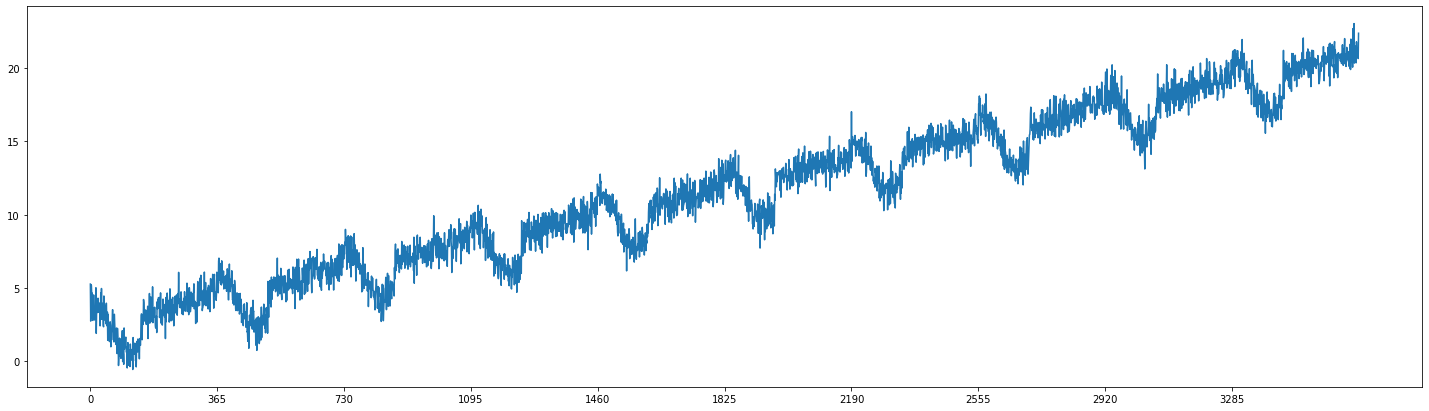

In [5]:
def trend(time, slope):
  return (time/200) * (1.0012**slope);

def seasonality(time, period):
  season = (time % period)/period
  return np.where(season < 0.4, 2*np.cos(10 * season), season)

def noise(time, noise_level, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.normal(size=len(time)) * noise_level

num_years = 10
period = 365
time = np.array(np.arange(period * num_years))
baseline = 2
slope = 0.1
noise_level = 0.7
series = baseline + seasonality(time, period) + trend(time, slope) + noise(time, noise_level)

plt.figure(figsize=(25,7))
plt.plot(series)
plt.xticks(period * np.arange(num_years))
plt.show()

In [6]:
X = []
Y = []
window_size = 5
for i in range(len(series) - window_size):
  X.append(series[i: i + window_size])
  Y.append(series[i + window_size])

X = np.array(X)
Y = np.array(Y)

years_to_predict = 4
split_time = period * (num_years - years_to_predict)
X_train = X[:split_time]
Y_train = Y[:split_time]

X_val = X[split_time:]
Y_val = Y[split_time:]

## LSTM

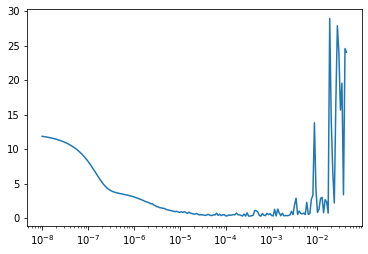

In [34]:
def train_LSTM(X_train, Y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(256, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: 25*x)
  ])

  optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.Huber())
  
  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/30))
  
  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  epochs = 200
  history = model.fit(X_train, Y_train, 
                      validation_split=0.2, 
                      verbose=False,
                      epochs=epochs,
                      callbacks=[lr_scheduler])
  
  return (model, history)


model, history = train_LSTM(X_train, Y_train)
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.show()

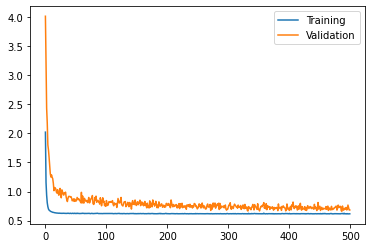

In [36]:
def train_LSTM(X_train, Y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(256, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: 25*x)
  ])

  optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.Huber(),
                metrics = 'mae')
  
  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  epochs = 500
  history = model.fit(X_train, Y_train, 
                      validation_split=0.2, 
                      verbose=False, 
                      epochs=epochs)
  
  return (model, history)


model, history = train_LSTM(X_train, Y_train)
plt.plot(history.history['mae'], label="Training")
plt.plot(history.history['val_mae'], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

In [37]:
def plot_prediction(predictions, label=None):
  plt.figure(figsize=(22,7))
  plt.plot(Y_val, label="True predictions")
  plt.plot(predictions, label=label)
  plt.show()

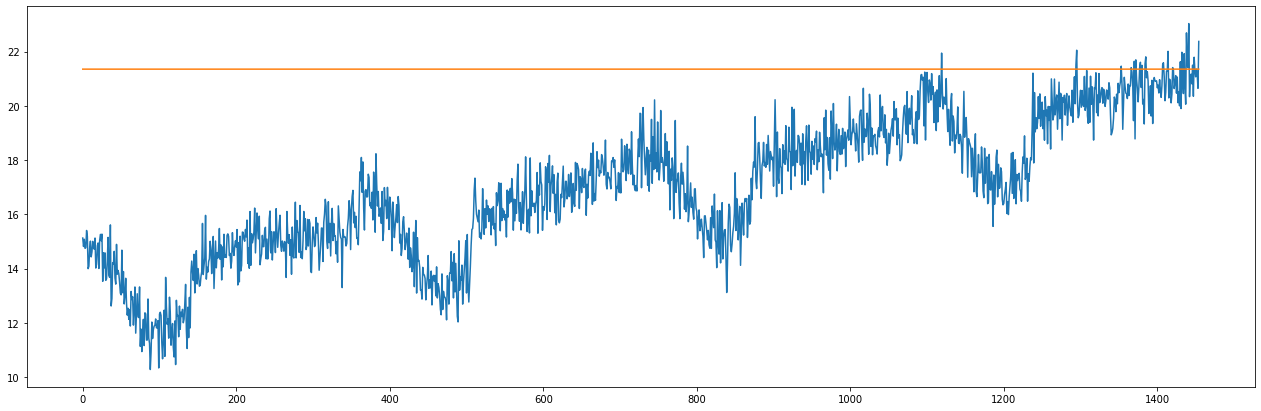

In [43]:
def one_time_prediction(model):
  predictions = []
  predictions = model.predict(X_val.reshape((-1, window_size, 1)))
  plot_prediction(predictions, label="One-Time Prediction")

one_time_prediction(model)

### Rolling Window Prediction

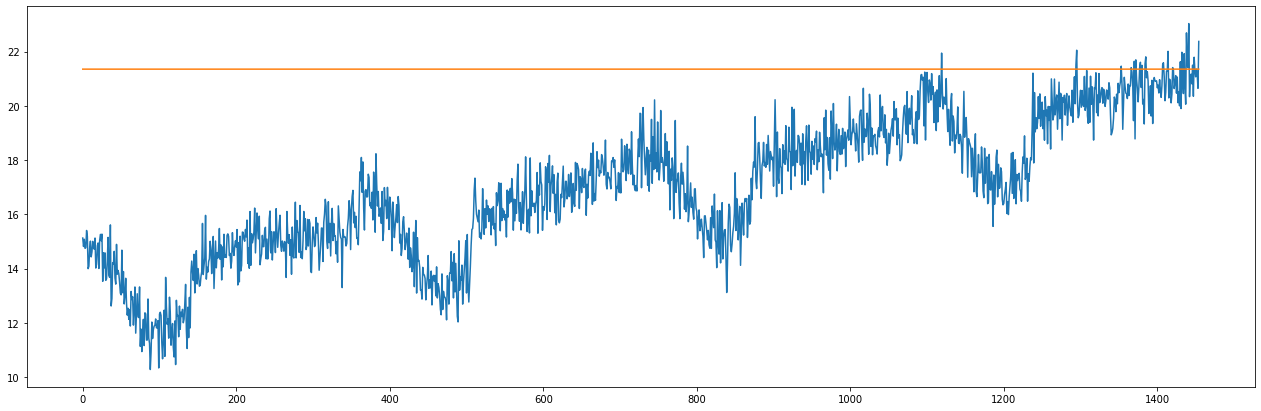

In [44]:
def rolling_window_prediction(model):
  predictions = []
  window = X_val[-1]
  for features in X_val:
    prediction = model.predict(features.reshape((1, -1, 1)))[0,0]
    predictions.append(prediction)
    
    window = np.roll(window, shift=-1)
    window[-1] = prediction

  plot_prediction(predictions, label="Rolling Window")
  
rolling_window_prediction(model)

# Preprocessed with CNN

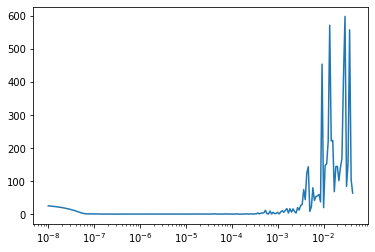

In [54]:
def train_LSTM_withCNN(X_train, Y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=2, padding='causal',activation='relu', input_shape=(None, 1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: 100*x)
  ])

  optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.Huber())
  
  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/30))
  
  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  epochs = 200
  history = model.fit(X_train, Y_train, 
                      validation_split=0.2, 
                      verbose=False,
                      epochs=epochs,
                      callbacks=[lr_scheduler])
  
  return (model, history)


model, history = train_LSTM_withCNN(X_train, Y_train)
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.show()

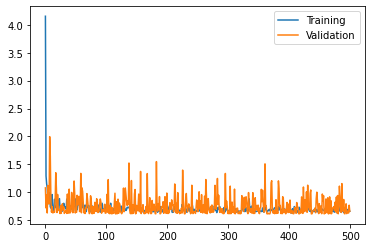

In [55]:
def train_LSTM(X_train, Y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=2, padding='causal',activation='relu', input_shape=(None, 1)),
    tf.keras.layers.LSTM(64, return_sequences=True,),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: 100*x)
  ])

  optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.Huber(),
                metrics = 'mae')
  
  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  epochs = 500
  history = model.fit(X_train, Y_train, 
                      validation_split=0.2, 
                      verbose=False, 
                      epochs=epochs)
  
  return (model, history)


model, history = train_LSTM(X_train, Y_train)
plt.plot(history.history['mae'], label="Training")
plt.plot(history.history['val_mae'], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

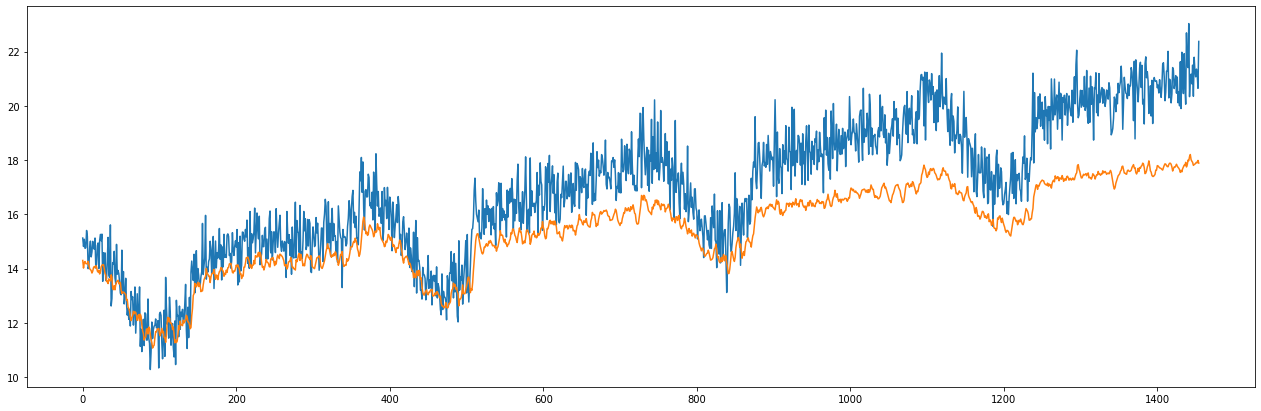

In [56]:
one_time_prediction(model)

### Rolling Window Prediction

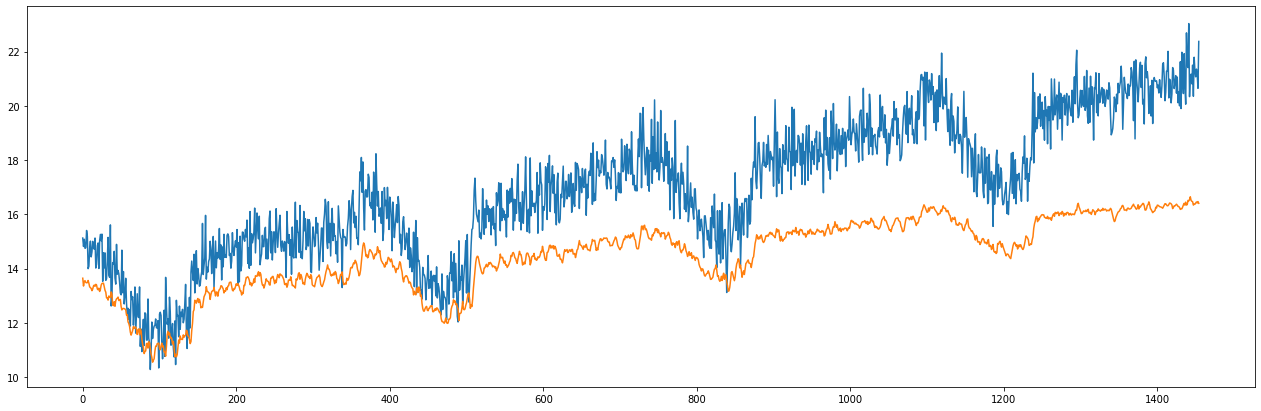

In [53]:
rolling_window_prediction(model)

# CNN dilations

In [133]:
def train_dilated_CNNs(X_train, Y_train, epochs=200, schedule_lr=False, lr=None):
  if not schedule_lr and lr is None:
    raise "Provide learning rate! or set schedule_lr=True "

  tf.keras.backend.clear_session()
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((window_size, 1))
  ])
  for dilation_rate in [1, 2, 4, 8, 16, 32, 64]:
    model.add(tf.keras.layers.Conv1D(32, kernel_size=2,
                                activation='relu', 
                                padding='causal',
                                strides=1,
                                dilation_rate=dilation_rate))
  model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

  model.compile(optimizer='adam',loss=tf.keras.losses.Huber(), metrics='mae')

  callbacks = []
  if schedule_lr:
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda e: 1e-8 * 10 ** (e/30))
    callbacks.append(lr_scheduler)

  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  history = model.fit(X_train, Y_train, 
                      validation_split=0.2,
                      verbose=False,
                      epochs=epochs,
                      callbacks=callbacks)

  return (model, history)

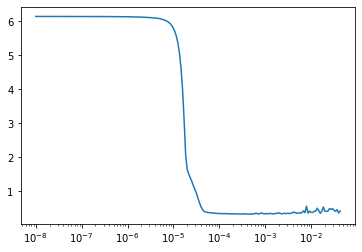

In [134]:
model, history = train_dilated_CNNs(X_train, Y_train, schedule_lr=True)
plt.semilogx(history.history['lr'], history.history['loss'])
plt.show()

In [135]:
model, history = train_dilated_CNNs(X_train, Y_train, lr=1e-4)

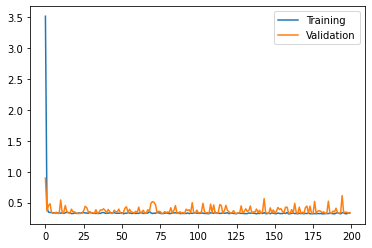

In [136]:
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

In [137]:
# one_time_prediction(model)
predictions = model.predict(np.expand_dims(X_val, axis=-1))
predictions = model.predict(X_val.reshape(-1, window_size, 1))
# plot_prediction(predictions, label="One Time Prediction")
model.summary()
# predictions[0]
predictions.shape
# X_val[0]
# predictions = model.predict(X_val.reshape((-1, window_size, 1)))
# plot_prediction(predictions, label="One-Time Prediction")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 5, 32)             2

(1455, 5, 1)